#### PRELIMINARIES

**NB this notebooks runs in Python 3.7**

In [1]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
import seaborn as sns

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

#### FUNCTION TO MAKE A PREDICTION ERROR LOG / FLAG

The function below calculates the difference between a predicted and a target curve and flags differences based on a user-defined distance (in standard deviation units) from the mean difference.

**NB it is now in Bruge's Petrophysics module**

From MyCarta's  [Geoscience_ML_notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb).


Method 1: difference between curves larger than mean difference plus/minus 1 std

Future work
- Method 2: curve slopes have opposite sign
- Method 3: opposite sign OR difference larger than mean plus 1 std

In [2]:
def error_flag(pred, actual, dev=1, method=1):
    """Make error flag using three methods"""
    
    ###### input ######
    
    # predicted = predicted log
    
    # actual =  original log
    
    # method 1: difference between logs larger than mean difference plus 1 std
    
    # Untested, not included:
    # method 2: slopes have opposite sign. Requires depth log for derivative to use differ function
    # method 3: opposite sign OR difference larger than mean plus 1 std
    

    ###### output ######
    
    # flag =  error flag
    
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1   
    elif method == 2:  
        pass
    elif method == 3:
        pass

    
    return flag

#### IMPORT DATA FOR FIRST EXAMPLE

I will use the result from Alessandro Amato del Monte's [Inverse Gardner Notebook](https://github.com/aadm/geophysical_notes/blob/master/inverse_gardner.ipynb), where he shows how to econstruct a velocity log from density log using optimized alpha and beta parameters for his inverse gardner function, found via `scipy.curve_fit`.

In [3]:
logs1 = pd.read_csv('../data/aadm_gardner.csv')
logs1.describe()

,depth,gr,vp_hole,vp_no_hole,vp_gardner,vp_rebuilt
count,4117.000000,4117.000000,3789.000000,4117.000000,328.000000,4117.000000
mean,2326.892000,72.785125,3037.046267,2984.389630,2361.049371,2983.189822
std,181.145666,14.464120,423.877490,444.671505,51.245128,446.180764
min,2013.252800,48.368700,1439.900000,1439.900000,2238.841631,1439.900000
25%,2170.072500,60.683100,2736.700000,2611.300000,2322.305286,2609.000000
50%,2326.892100,68.026600,3074.800000,3038.158346,2356.921449,3038.158346
75%,2483.711700,83.557200,3263.700000,3251.100000,2403.044013,3251.100000
max,2640.531200,136.512800,4431.000000,4431.000000,2515.005238,4431.000000


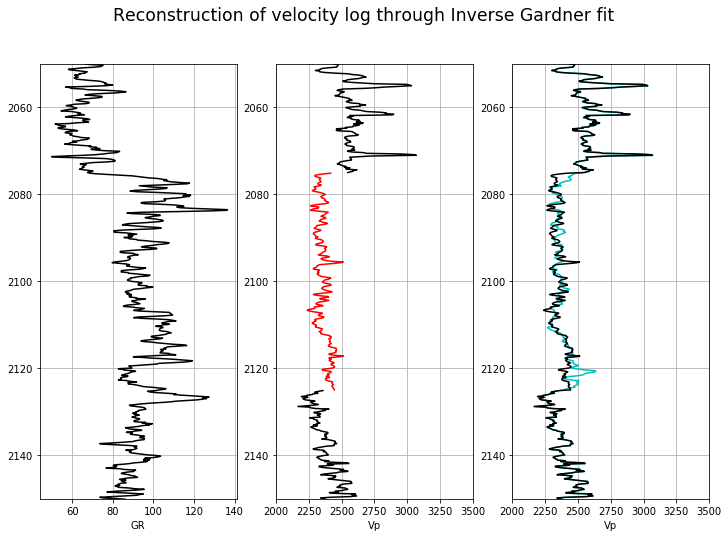

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(logs1.gr,logs1.depth,'-k')
ax[0].set_xlabel('GR')
ax[1].plot(logs1.vp_hole,logs1.depth,'-k')
ax[1].plot(logs1.vp_gardner,logs1.depth,'-r')
ax[1].set_xlabel('Vp')
ax[1].set_xlim(2000,3500)
ax[2].plot(logs1.vp_no_hole,logs1.depth,'-c')
ax[2].plot(logs1.vp_rebuilt,logs1.depth,'-k')
ax[2].set_xlabel('Vp')
ax[2].set_xlim(2000,3500)
for aa in ax:
    aa.set_ylim(2150,2050)
    aa.grid()
plt.suptitle('Reconstruction of velocity log through Inverse Gardner fit', fontsize='xx-large');

In the figure above, reproduced from Alessandro's notebook, the velocity log with the missing data is displayed together with the reconstructed portion (respectively black and red curves in the middle plot), and also a comparison between the fully-rebuilt velocity log (rightmost plot, black curve) and the original log as it was recorded before artificially creating a gap in it (cyan curve).

In [5]:
hole=(logs1.depth>2075) & (logs1.depth<2125)
flag = np.zeros(len(logs1.vp_rebuilt))
flag[hole] = error_flag(logs1.vp_rebuilt[hole], logs1.vp_no_hole[hole],  0.5)

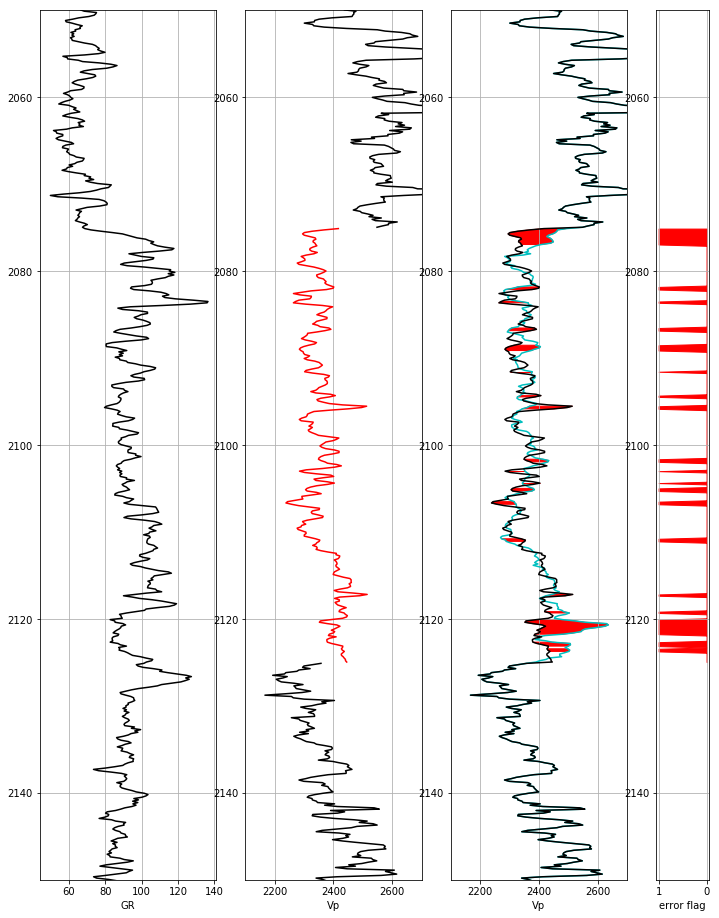

In [6]:
mi = 2100
ma = 2700
fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.3]) 

ax = plt.subplot(gs[0])
ax.plot(logs1.gr, logs1.depth,'-k')
ax.set_xlabel('GR')
ax.set_ylim(2150,2050)
ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs1.vp_hole, logs1.depth,'-k')
ax1.plot(logs1.vp_gardner, logs1.depth,'-r')
ax1.set_xlabel('Vp')
ax1.set_xlim(mi, ma)
ax1.set_ylim(2150,2050)
ax1.grid()

ax2 = plt.subplot(gs[2])
ax2.plot(logs1.vp_no_hole, logs1.depth,'-c')
ax2.plot(logs1.vp_rebuilt, logs1.depth,'-k')
ax2.fill_betweenx(logs1.depth[hole], logs1.vp_no_hole[hole], 
                  logs1.vp_rebuilt[hole], where=flag[hole]==1,
                  color = 'r', label='error flag')
ax2.set_xlabel('Vp')
ax2.set_xlim(mi, ma)
ax2.set_ylim(2150,2050)
ax2.grid()

ax3 = plt.subplot(gs[3])
ax3.fill_betweenx(logs1.depth[hole], flag[hole], 0, color = 'r')
ax3.invert_yaxis()
ax3.invert_xaxis()
ax3.set_xlabel('error flag')
ax3.set_ylim(2150,2050)
ax3.grid()

This figure is the same as above but now there is an extra track with the error flag on the right, and I also added fill between the predicted and reconstructed original according to the flag.

#### IMPORT DATA FOR SECOND EXAMPLE

I will use the latest result from my [Geoscience ML notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb). This is an evolving notebook in which I evaluate and compare the performance of different ML methods in predicting a geophysical log from a suite of other logs. THe current result is prediction of compressional sonic log using a linear model and the Gamma Ray, Neutron Porosity, and Bulk Density logs.

In [7]:
logs2 = pd.read_csv('../data/logs2.csv')
logs2.describe()

,DEPTH,ZONE_NUM,VP,predictedVP
count,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073
std,181.053325,2.154977,433.228662,418.308545
min,2013.410000,0.000000,2046.660000,2111.090000
25%,2168.930000,4.000000,2607.125000,2675.275000
50%,2325.670000,4.000000,3050.280000,3029.160000
75%,2482.415000,5.000000,3248.900000,3242.245000
max,2639.160000,9.000000,4088.760000,4049.990000


Original versus predicted sonic, as scatter plots.

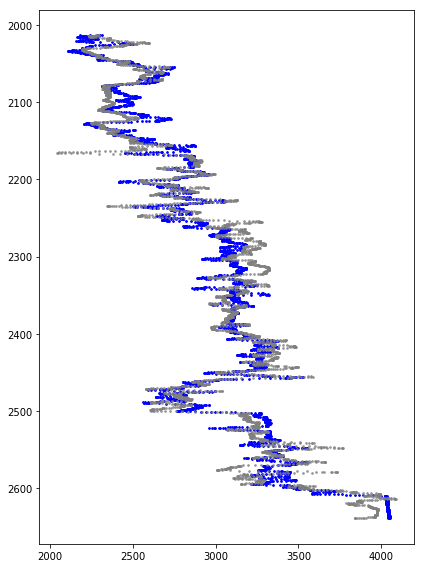

In [8]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs2["predictedVP"], logs2["DEPTH"], s = 3, color = 'b')
ax1.scatter(logs2["VP"], logs2["DEPTH"], s = 3, color = 'gray', alpha = 0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Original versus predicted sonic, as scatter plot mimicking lines.

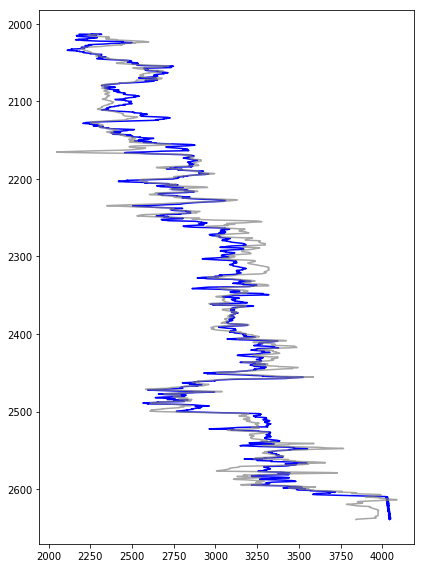

In [9]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'b')
ax1.plot( logs2["VP"], logs2["DEPTH"],'gray', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [10]:
flag = error_flag(logs2["predictedVP"], logs2["VP"], 1,  1)

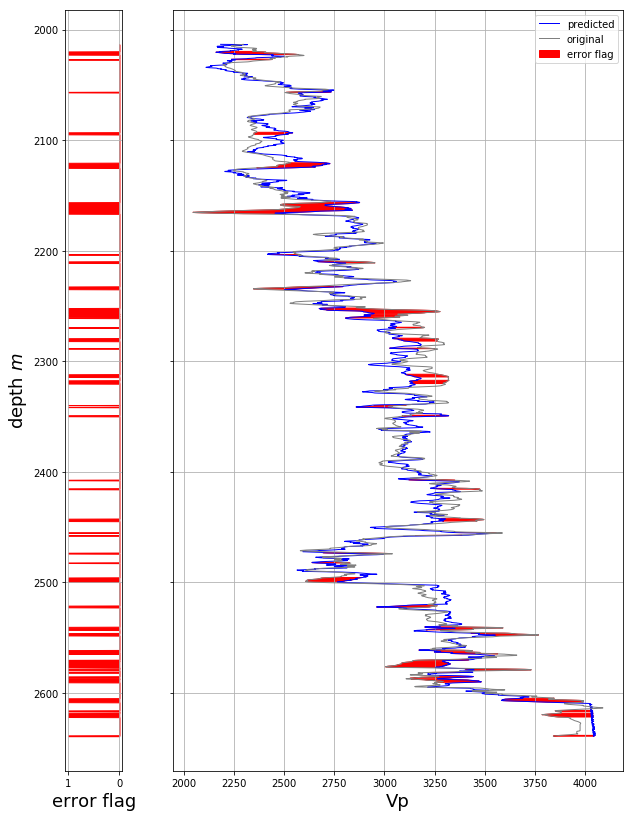

In [11]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=18)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)

ax1.legend()
    
ax1.grid()
#fig.savefig('file.png', dpi=250, bbox_inches='tight', pad_inches=0.2)
plt.show()


#### ADD A RESERVOIR FLAG

Load compilation of tops. Source:

http://factpages.npd.no/FactPages/Default.aspx?nav1=wellbore&nav2=PageView|Exploration|All&nav3=2635&culture=en

In [12]:
tops = pd.read_csv('../data/qsi_well2_tops.csv')
tops

,depth,name,id
0,1807,UNDEFINED,0
1,2027,BALDER,1
2,2076,SELE,2
3,2127,LISTA,3
4,2154,HEIMDAL,4
5,2183,OWC,5
6,2458,LISTA,6
7,2491,VALE,7
8,2501,TY,8
9,2583,VALE,9


Get reservoir top and bottom depths

In [13]:
top1 = np.float64(tops.loc[tops['name']=='HEIMDAL', ['depth']].values[0]) # top of Heimdal sand
top2 = np.float64(tops.loc[tops['name']=='OWC', ['depth']].values[0]) # Oil-Water Contact
#print(top1, top2)

In [14]:
oil = np.zeros(len(logs2["DEPTH"]))
logs2['oil_zone']=oil
logs2.loc[(logs2["DEPTH"]>top1) & (logs2["DEPTH"]<top2), 'oil_zone']= 1
logs2.describe(include='all')

,DEPTH,ZONE_NUM,VP,predictedVP,oil_zone
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073,0.046173
std,181.053325,2.154977,433.228662,418.308545,0.209884
min,2013.410000,0.000000,2046.660000,2111.090000,0.000000
25%,2168.930000,4.000000,2607.125000,2675.275000,0.000000
50%,2325.670000,4.000000,3050.280000,3029.160000,0.000000
75%,2482.415000,5.000000,3248.900000,3242.245000,0.000000
max,2639.160000,9.000000,4088.760000,4049.990000,1.000000


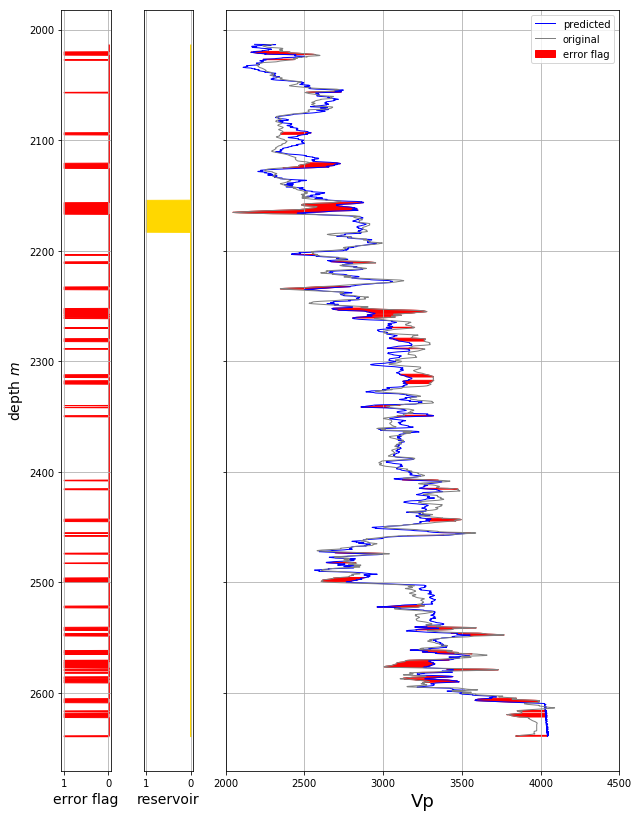

In [15]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.5,0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)
ax.grid()

ax1 = plt.subplot(gs[2])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.set_xlim((2000, 4500))
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')


ax2 = plt.subplot(gs[1])
ax2.fill_betweenx(logs2['DEPTH'],  0, logs2['oil_zone'],  color = 'gold')
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_yticks([])
ax2.set_xlabel('reservoir', size=14)
ax2.grid()

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)

ax1.legend()
    
ax1.grid()
#fig.savefig('file.png', dpi=250, bbox_inches='tight', pad_inches=0.2)
plt.show()


#### CALCULATING ERROR STATISTICS BY STRATIGRAPHYC UNIT IF ZONE LOG IS PROVIDED

Future work:  make zone log directly from tops



**NB HAVE NOT BUILT A TEST YET FOR THESE TWO METHODS**

In [16]:
logs2.describe(include='all')

,DEPTH,ZONE_NUM,VP,predictedVP,oil_zone
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073,0.046173
std,181.053325,2.154977,433.228662,418.308545,0.209884
min,2013.410000,0.000000,2046.660000,2111.090000,0.000000
25%,2168.930000,4.000000,2607.125000,2675.275000,0.000000
50%,2325.670000,4.000000,3050.280000,3029.160000,0.000000
75%,2482.415000,5.000000,3248.900000,3242.245000,0.000000
max,2639.160000,9.000000,4088.760000,4049.990000,1.000000


In [17]:
zones = list(logs2['ZONE_NUM'].unique())
zones

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [18]:
mean_abs_err = [np.mean(np.abs(logs2.loc[logs2.ZONE_NUM ==z, 'predictedVP'] 
                               -logs2.loc[logs2.ZONE_NUM ==z, 'VP'])) for z in zones]
mean_abs_err = np.array(mean_abs_err)
print(mean_abs_err)

[109.53 58.27 91.92 46.64 86.65 58.34 130.79 105.01 118.46 108.42]


In [19]:
def zone_thickness(d, zone):
    """ returns amount of flagged portion of a zone"""
    #### input ####
    # d= depth log (e.g. logs['DEPT'])
    # zone = stratigraphic zone (e.g. 1 = D1)
    
    th = np.amax(d[np.where(logs2['ZONE_NUM']== zone)]) - np.amin(d[np.where(logs2['ZONE_NUM']== zone)])

    return th

In [20]:
thicknesses =  np.array([zone_thickness(np.array(logs2['DEPTH']), z)  for z in zones])
thicknesses

array([12.34, 48.77, 50.90, 26.82, 303.89, 32.77, 9.90, 81.83, 14.78,
       42.37])